Vamos utilizar o tensorflow em conjunto com o keras para construir, compilar e treinar a nossa rede neuronal. Por isso vamos importar as bibliotecas necessárias.


In [2]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical

Antes de podermos treinar a rede é necessário obter o dataset. O keras possui um conjunto de datasets já embutidos, um destes é o MNIST. Vamos aproveitar para alterar o formato dos dados de entrada de forma a respeitarem a entrada da rede que vamos construir.

In [3]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

# Guardamos 10 mil imagens para o conjunto de validação e 50 mil para o de teste
val_images   = train_images[50000:60000]
train_images = train_images[0:50000]

val_labels   = train_labels[50000:60000]
train_labels = train_labels[0:50000]

11493376/11490434 [==============================] - 0s 0us/step


Este passo é opcional, porém extremamente importante
Normalizar os dados das imagens facilita o processo de treino da rede neuronal
pois diminui a ordem de grandeza com que é trabalhada, 
neste caso em vez de termos dados no conjunto [0, 255] passamos a ter dados no conjunto [0.0, 1.0]

In [4]:
train_images, val_images, test_images = train_images / 255.0, val_images/ 255.0, test_images / 255.0

train_labels, val_labels, test_labels = to_categorical(train_labels), to_categorical(val_labels), to_categorical(test_labels)

Agora que temos um dataset normalizado vamos construir a rede neuronal.

In [5]:
model = tf.keras.models.Sequential()
# Como as nossas imagens tem o formato (28,28, 1) definimo-lo como formato de entrada da primeira camada da rede
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# A parte classificatória da CNN é composta por camadas densamente conectadas,
# assim sendo, é necessário alterar o formato da saída da última camada convolucional
# para um vetor. A camada Flatten altera o formato da sua entrada para um vetor, tal como era necessário.
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
# O output da última camada é especial, pois corresponde ao número de classes que o nosso problema possui
model.add(layers.Dense(10, activation='softmax'))

# P
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                3

Para podermos treinar esta rede é ainda necessário decidir:
 - Métrica;
 - Função de perda;
 - Otimizador.

 Este processo é chamado de processo de compilação.

A escolha deste parametros pode ser feita tendo como base a seguinte tabela:

| Tipo de Problema              | Ativação da Última Camada | Função de Perda            |
| :---------------------------- | :------------------------ | :------------------------- |
| Classificação Binária         | sigmoid                   | binary_crossentropy        |
| N-Classes, 1 label            | softmax                   | categorical_crossentropy   |
| N-Classes, M-labels           | sigmoid                   | binary_crossentropy        |
| Regressão abritária           | nenhum                    | mse                        |
| Regressão de valores [0, 1]   | nenhum                    | mse ou binary_crossentropy |

In [6]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

Para treinar uma rede neuronal em Tensorflow, podemos utilizar a função `fit`. No nosso caso vamos treinar a nossa rede durante 5 épocas, e cada lote irá conter 64 imagens.

Como o nosso conjunto de treino tem 50 mil imagens, uma época será composta por 782 passos.

In [7]:
history = model.fit(train_images, train_labels, epochs=5, batch_size=64, validation_data=(val_images, val_labels))

Epoch 1/5
782/782 [==============================] - 42s 54ms/step - loss: 0.1987 - accuracy: 0.9385 - val_loss: 0.0589 - val_accuracy: 0.9821
Epoch 2/5
782/782 [==============================] - 42s 53ms/step - loss: 0.0524 - accuracy: 0.9837 - val_loss: 0.0456 - val_accuracy: 0.9879
Epoch 3/5
782/782 [==============================] - 41s 53ms/step - loss: 0.0362 - accuracy: 0.9888 - val_loss: 0.0439 - val_accuracy: 0.9865
Epoch 4/5
782/782 [==============================] - 41s 53ms/step - loss: 0.0272 - accuracy: 0.9913 - val_loss: 0.0429 - val_accuracy: 0.9895
Epoch 5/5
782/782 [==============================] - 41s 53ms/step - loss: 0.0212 - accuracy: 0.9933 - val_loss: 0.0398 - val_accuracy: 0.9892


Vamos gerar o gráfico da precisão da rede, para observarmos melhor a evolução do modelo.

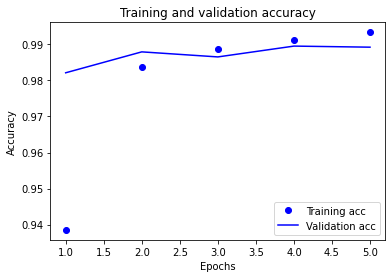

In [9]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

history_dict = history.history
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')

plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Depois de satisfeitos com os resultados nos conjuntos de treino e de validação. Vamos realizar o teste final.

In [10]:
# Avaliação
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('acc: ', test_acc * 100)
print('loss:', test_loss * 100)

313/313 [==============================] - 3s 9ms/step - loss: 0.0300 - accuracy: 0.9910
acc:  99.09999966621399
loss: 2.995535358786583
